In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = ""
project_dir = "01_dnn_pt"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/01_dnn_pt


In [ ]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.3.1+cu121


In [ ]:
# !pip install torch==1.1.0 torchvision==0.3.0

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import check_util.checker as checker
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.3.1+cu121
GPU 사용 가능 여부: False


In [ ]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

In [ ]:
from torch.utils.data import DataLoader

root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

train_loader = DataLoader(dataset = train_data,
                          batch_size = batch_size,
                          shuffle = True)
test_loader = DataLoader(dataset = test_data,
                          batch_size = batch_size,
                          shuffle = False)

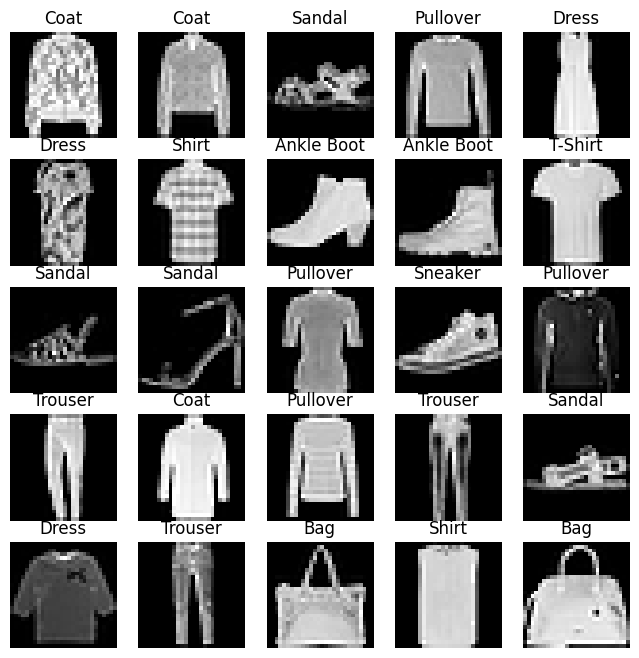

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환

    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(28*28,512),    # Linear_1 해당하는 층
            nn.BatchNorm1d(512),    # BatchNorm_1 해당하는 층
            nn.ReLU()     # ReLU_1 해당하는 층
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512,10)    # Linear_2 해당하는 층
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

In [ ]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
model = DNN().to(device)
model.apply(weights_init) # 모델에 weight_init 함수를 적용하여 weight를 초기화

Parameter containing:
tensor([[-0.0437, -0.0047,  0.0671,  ..., -0.0125, -0.0129, -0.0146],
        [ 0.0727, -0.0370,  0.0367,  ...,  0.0184,  0.0512,  0.0268],
        [-0.0182,  0.0375, -0.0141,  ...,  0.0072, -0.0228,  0.0097],
        ...,
        [-0.0409,  0.0340, -0.0123,  ...,  0.0333,  0.0048,  0.0379],
        [ 0.0204, -0.0544, -0.0059,  ...,  0.0047, -0.0267,  0.0256],
        [ 0.0169,  0.0197, -0.0354,  ...,  0.0029, -0.0067, -0.0555]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0367,  0.0610, -0.1070,  ...,  0.0567,  0.0033,  0.0320],
        [ 0.0578, -0.0620,  0.0097,  ...,  0.0025, -0.0586, -0.0876],
        [-0.0626,  0.0149,  0.0781,  ...,  0.0642, -0.1264, -0.0073],
        ...,
        [ 0.0134,  0.0056,  0.1168,  ...,  0.0135,  0.0050,  0.1229],
        [ 0.0017, -0.0512, -0.0223,  ..., -0.1189,  0.0555, -0.0026],
        [-0.0321, -0.0273,  0.0709,  ..., -0.1396,  0.0144, -0.0953]],
       requires_grad=True)


DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [100/600], Loss: 0.4567, Accuracy: 81.00%
Epoch [1/5], Step [200/600], Loss: 0.4531, Accuracy: 82.00%
Epoch [1/5], Step [300/600], Loss: 0.4441, Accuracy: 83.00%
Epoch [1/5], Step [400/600], Loss: 0.3186, Accuracy: 87.00%
Epoch [1/5], Step [500/600], Loss: 0.2525, Accuracy: 92.00%
Epoch [1/5], Step [600/600], Loss: 0.3544, Accuracy: 86.00%
Epoch [2/5], Step [100/600], Loss: 0.1778, Accuracy: 92.00%
Epoch [2/5], Step [200/600], Loss: 0.3458, Accuracy: 90.00%
Epoch [2/5], Step [300/600], Loss: 0.3175, Accuracy: 89.00%
Epoch [2/5], Step [400/600], Loss: 0.3339, Accuracy: 90.00%
Epoch [2/5], Step [500/600], Loss: 0.5491, Accuracy: 81.00%
Epoch [2/5], Step [600/600], Loss: 0.2688, Accuracy: 90.00%
Epoch [3/5], Step [100/600], Loss: 0.2069, Accuracy: 91.00%
Epoch [3/5], Step [200/600], Loss: 0.3818, Accuracy: 86.00%
Epoch [3/5], Step [300/600], Loss: 0.1722, Accuracy: 94.00%
Epoch [3/5], Step [400/600], Loss: 0.3251, Accuracy: 89.00%
Epoch [3/5], Step [500/600], Loss: 0.236

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()

    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 88.00%


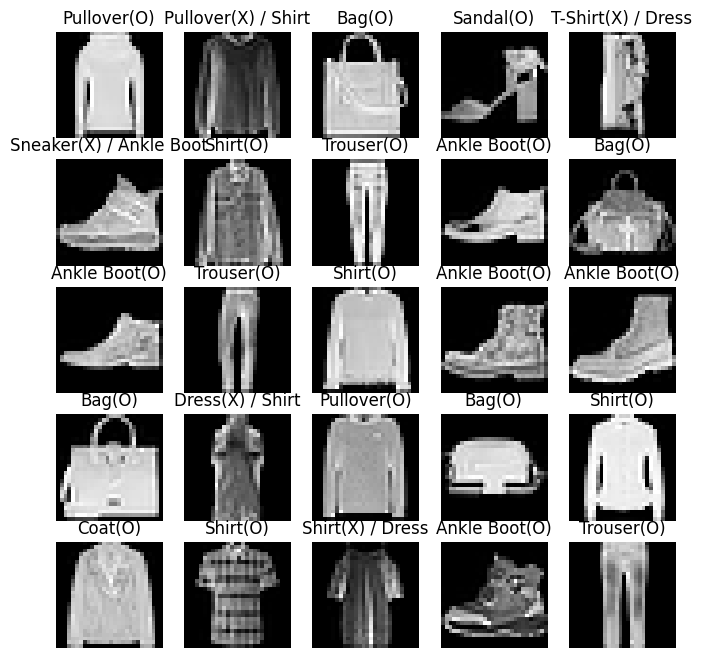

In [ ]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()

---

- Multi layer perceptron을 설계할 수 있다.
- 네트워크에 ReLU, Batch normalization를 적용할 수 있다.
- DataLoader를 이용하여 데이터를 로드할 수 있다.
- 원하는 방식으로 가중치를 초기화할 수 있다.
- Loss function과 optimizer를 정의할 수 있다.
- Loss를 측정하고 gradient를 계산해 모델 파라미터를 업데이트할 수 있다.
- 학습한 모델의 성능을 test 할 수 있다.